<a href="https://colab.research.google.com/github/minhbao1705/AIO2023_HOMEWORK/blob/main/231119_Resnet_weather_cls_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Import libraries**

In [16]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## **2. Read dataset**

Đọc các folder và đưa vào một dictionary

In [17]:
root_dir = '/content/drive/MyDrive/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name \
      for label_idx, class_name in enumerate(
          sorted(os.listdir(root_dir))
      )
}

Đọc toàn bộ đường dẫn các ảnh trong bộ dữ liệu cũng như label tương ứng:

In [18]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  for img_filename in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_filename)
    img_paths.append(img_path)
    labels.append(label_idx)

## **3. Train, val, test split**

Chia bộ dữ liệu train, val, test

In [19]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

Xây dựng class pytorch datasets:

In [20]:
class WeatherDataset(Dataset):
  def __init__(
      self,
      X, y,
      transform=None
  ):
      self.transform = transform
      self.img_paths = X
      self.labels = y

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)

      return img, self.labels[idx]

## **5. Create data preprocessing function (transforms)**

Để dữ liệu ảnh đầu vào được đồng bộ về kích thước cũng như đơn giản hóa, chúng ta sẽ xây dựng hàm tiền xử lý ảnh như sau:

In [21]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0

  return normalized_img

Các kỹ thuật được áp dụng: resize ảnh, đổi về tensor và chuẩn hóa giá trị pixel về khoảng (0, 1).

## **6. Create dataloader**

**Khai báo datasets object cho ba bộ train, val, test:**

In [22]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

**Khai báo dataloader:**

In [23]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## **7. Create model**

**RESNET**

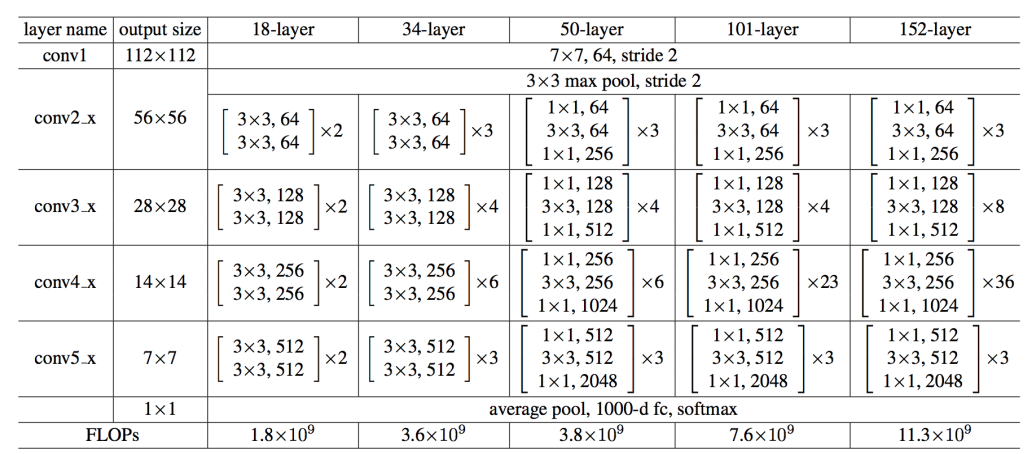

Triển khai Residual Block

In [24]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(out_channels)

    self.downsample = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels)
      )
    self.relu = nn.ReLU()

  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x += self.downsample(shortcut)
    x = self.relu(x)

    return x

Triển khai toàn bộ kiến trúc ResNet

In [25]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_blocks_lst, n_classes):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = self.create_layer(residual_block, 32, 32, n_blocks_lst[0], 1)
    self.conv3 = self.create_layer(residual_block, 32, 64, n_blocks_lst[1], 2)
    self.conv4 = self.create_layer(residual_block, 64, 128, n_blocks_lst[2], 2)
    self.conv5 = self.create_layer(residual_block, 128, 256, n_blocks_lst[3], 2)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(256, n_classes)

  def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
    blocks = []
    first_block = residual_block(in_channels, out_channels, stride)
    blocks.append(first_block)

    for idx in range(1, n_blocks):
      block = residual_block(out_channels, out_channels, stride)
      blocks.append(block)

    block_sequential = nn.Sequential(*blocks)

    return block_sequential

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.fc1(x)

    return x


In [26]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

Xây dựng hàm đánh giá model

In [27]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

## **8. Training**

In [28]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses) / len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(
        model, val_loader,
        criterion, device
    )
    val_losses.append(val_loss)

    print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

  return train_losses, val_losses


Khai báo hàm loss và thuật toán huấn luyện

In [29]:
lr = 1e-3
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

Thực hiện huấn luyện

In [30]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 2.4097	Val loss: 2.4210
EPOCH 2:	Train loss: 2.2778	Val loss: 2.3823
EPOCH 3:	Train loss: 2.1683	Val loss: 2.2477
EPOCH 4:	Train loss: 2.0796	Val loss: 2.1280
EPOCH 5:	Train loss: 2.0072	Val loss: 2.0339
EPOCH 6:	Train loss: 1.9416	Val loss: 2.0100
EPOCH 7:	Train loss: 1.8796	Val loss: 1.9814
EPOCH 8:	Train loss: 1.8274	Val loss: 1.9199
EPOCH 9:	Train loss: 1.7651	Val loss: 1.8485
EPOCH 10:	Train loss: 1.7183	Val loss: 1.8437
EPOCH 11:	Train loss: 1.6859	Val loss: 1.8277
EPOCH 12:	Train loss: 1.6361	Val loss: 1.7699
EPOCH 13:	Train loss: 1.6046	Val loss: 1.7706
EPOCH 14:	Train loss: 1.5627	Val loss: 1.7000
EPOCH 15:	Train loss: 1.5202	Val loss: 1.6949
EPOCH 16:	Train loss: 1.4891	Val loss: 1.6381
EPOCH 17:	Train loss: 1.4524	Val loss: 1.5933
EPOCH 18:	Train loss: 1.4108	Val loss: 1.5735
EPOCH 19:	Train loss: 1.3935	Val loss: 1.5730
EPOCH 20:	Train loss: 1.3658	Val loss: 1.6088
EPOCH 21:	Train loss: 1.3523	Val loss: 1.5112
EPOCH 22:	Train loss: 1.3207	Val loss: 1.51

## **9.Evaluation**

In [31]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5950473415877641
Test accuracy:  0.5901639344262295
